In [1]:
import os

import aircraft_detector.ego_noise_prediction.feature_extraction as fe


# assign root directory
root_directory = os.path.join(os.pardir, os.pardir, os.pardir, 'Data')
# settings for feature extraction
feature_settings = {'feature': 'Mel'}

/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


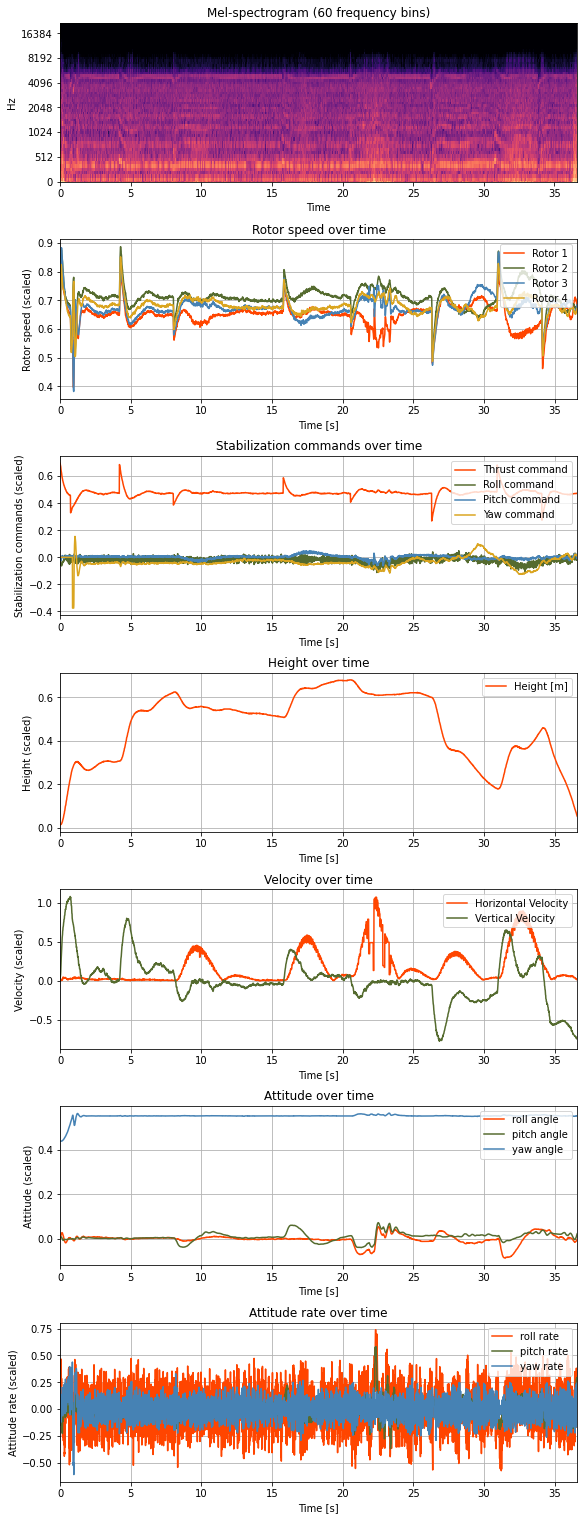

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [2]:
extractor = fe.FeatureExtraction(root_directory, feature_settings)  # default parameters are used

# extract the spectra from the audio
#extractor.extract_spectra()
# 'extract' the relevant states
#extractor.extract_states()
# synchronize the exctracted spectra and states
#extractor.synchronize_data()

# plot some examples
#extractor.plot_features('Train', states=['rpm', 'cmd'])
fig = extractor.plot_features('Test', states=['rpm', 'cmd', 'height', 'vel', 'angles', 'rates'])
fig.savefig('enp_states.eps', format='eps')

In [5]:
from ax.service.managed_loop import optimize
import pandas as pd

import aircraft_detector.ego_noise_prediction.prediction as enp

import time

# set ranges for optimization (units multiplied by 10)
ranges_mlp =  [
    {"name": 'Linear_layers', "type": 'range', "bounds": [1, 3], "value_type": 'int'},
    {"name": 'Linear_1_out_features_10', "type": 'range', "bounds": [4, 20], "value_type": 'int'},
    {"name": 'Linear_2_out_features_10', "type": 'range', "bounds": [4, 20], "value_type": 'int'},
    {"name": 'Linear_3_out_features_10', "type": 'range', "bounds": [4, 20], "value_type": 'int'},
]

ranges_gru = [
    {"name": 'GRU_layers', "type": 'range', "bounds": [1, 2], "value_type": 'int'},
    {"name": 'GRU_1_hidden_size_10', "type": 'range', "bounds": [4, 12], "value_type": 'int'},  
    {"name": 'GRU_2_hidden_size_10', "type": 'range', "bounds": [4, 12], "value_type": 'int'}, 
    {'name': 'Linear_layers', "type": 'range', "bounds": [1, 2], "value_type": 'int'},
    {'name': 'Linear_1_out_features_10', 'type': 'range', 'bounds': [4, 20], 'value_type': 'int'},
    {'name': 'Linear_2_out_features_10', 'type': 'range', 'bounds': [4, 20], 'value_type': 'int'},
]

ranges_lstm = [
    {"name": 'LSTM_layers', "type": 'range', "bounds": [1, 2], "value_type": 'int'},
    {"name": 'LSTM_1_hidden_size_10', "type": 'range', "bounds": [4, 12], "value_type": 'int'},  
    {"name": 'LSTM_2_hidden_size_10', "type": 'range', "bounds": [4, 12], "value_type": 'int'}, 
    {'name': 'Linear_layers', "type": 'range', "bounds": [1, 2], "value_type": 'int'},
    {'name': 'Linear_1_out_features_10', 'type': 'range', 'bounds': [4, 20], 'value_type': 'int'},
    {'name': 'Linear_2_out_features_10', 'type': 'range', 'bounds': [4, 20], 'value_type': 'int'},
]

# network training settings
optimizer = {'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 0.01, 'amsgrad': False}
lr_scheduler = {'scheduler': 'ReduceLROnPlateau', 'factor': 0.2, 'patience': 8, 'verbose': True}
train_settings = {
                'epochs': 20,
                'es_patience': 15,
                'batch_size': 256,
                'optimizer': optimizer,
                'scheduler': lr_scheduler,
                'random_seed': 42,
            }
states_settings = {"states": [
            "rpm",
            "rpm_delta",
            "cmd",
            "cmd_delta",
            "height",
            "vel",
            "acc",
            "angles",
            "rates",
        ]}
max_context = 10
bic_trials = 20
network_ranges = [ranges_mlp, ranges_gru, ranges_lstm]
network_names = ['MLP', 'GRU', 'LSTM']
df_results = pd.DataFrame(columns=['Loss', 'Context', 'Type', 
                                   'Recurrent Layers', 'Recurrent Units', 
                                   'Dense Layers', 'Dense Units', 'States'])

def update_results(ax_experiment, df_results, states_settings, net_name):
    # store results in dataframe and format it
    df = ax_experiment.fetch_data().df
    df.drop_duplicates(subset=['arm_name'], inplace=True) 
    df.drop(columns=['metric_name', 'arm_name', 'sem', 'trial_index'], inplace=True)
    
    # get list of used parameters
    used_parameters = [ax_experiment.arms_by_signature[key].parameters 
                       for key in ax_experiment.arms_by_signature]

    # get number of layers, units per layer per trial
    for i in range(len(used_parameters)):
        recurrent_layers = used_parameters[i].get('%s_layers' % net_name, 0)
        #if net_name == 'MLP':
        #    recurrent_units = 'None'
        #else:
        recurrent_units = [
            10 * int(used_parameters[i]['%s_%d_hidden_size_10' % (net_name, j+1)]) 
            for j in range(used_parameters[i].get('%s_layers' % net_name, 0))
        ]
        dense_layers = used_parameters[i]['Linear_layers']
        dense_units = [
            10 * int(used_parameters[i]['Linear_%d_out_features_10' % (j+1)]) 
            for j in range(used_parameters[i]['Linear_layers'])]
        
        # add row to existing df
        new_row = [
            df['mean'].iloc[i], 
            states_settings['context_frames'], 
            net_name, 
            recurrent_layers, 
            recurrent_units,
            dense_layers,
            dense_units,
            states_settings['states']
        ]
        df_results = df_results.append(
            pd.Series(new_row, df_results.columns), ignore_index=True
        )
    
    return df_results
    
time_start = time.time()
# loop over context frames
for context in range(max_context + 1):
    states_settings['context_frames'] = context 
    # initialize predictor class with spectrum and states settings
    predictor = enp.EgoNoisePredictor(
        root_directory,
        feature_settings,
        states_settings
    )
    # load the data
    predictor.load_datasets()
    # feed the train settings (constant) to the tuner (ax checks signature, partial does not work)
    tuner = lambda p: predictor.tune_hyperparameters(p, train_settings)
    # loop over network types
    for net_name, net_range in list(zip(network_names, network_ranges)):
        # perform optimization
        best_hyperparameters, best_values, experiment, optimization_model = optimize(
            parameters=net_range,
            experiment_name='tuning',
            objective_name='mean_squared_error',
            evaluation_function=tuner,
            minimize=True,
            total_trials=bic_trials,
            random_seed=42
        )
        # add to dataframe
        df_results = update_results(experiment, df_results, states_settings, net_name)
        
        print("net type: '%s', context: %d/%d, time elapsed: %d seconds" 
              % (net_name, context, max_context, time.time() - time_start))
        

[INFO 02-19 07:35:01] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 07:35:01] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:35:01] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 16370.


[INFO 02-19 07:35:11] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 8860.


[INFO 02-19 07:35:19] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 32350.


[INFO 02-19 07:35:29] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 12520.


[INFO 02-19 07:35:39] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 13260.


[INFO 02-19 07:35:47] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 36170.


[INFO 02-19 07:35:58] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:36:08] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 44320.


[INFO 02-19 07:36:19] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:36:30] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:36:40] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:36:51] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:02] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:13] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:24] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:35] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:46] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:37:56] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:38:07] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:38:18] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 40130.


[INFO 02-19 07:38:29] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 07:38:29] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:38:29] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 0/10, time elapsed: 212 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 07:38:42] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 07:38:54] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 07:39:10] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 07:39:24] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 07:39:37] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:39:49] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 40500.


[INFO 02-19 07:40:02] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:40:15] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 56350.


[INFO 02-19 07:40:28] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 43120.


[INFO 02-19 07:40:41] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 47370.


[INFO 02-19 07:40:54] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 41810.


[INFO 02-19 07:41:08] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 56350.


[INFO 02-19 07:41:21] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:41:35] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:41:48] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:42:01] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:42:15] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:42:28] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:42:41] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 48780.


[INFO 02-19 07:42:55] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 07:42:55] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:42:55] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 0/10, time elapsed: 479 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 07:43:09] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 07:43:21] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 07:43:38] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 07:43:53] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 07:44:06] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 07:44:19] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 07:44:32] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 07:44:46] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 33620.


[INFO 02-19 07:44:59] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 36950.


[INFO 02-19 07:45:12] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 27260.


[INFO 02-19 07:45:26] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 34730.


[INFO 02-19 07:45:39] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:45:53] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 31400.


[INFO 02-19 07:46:07] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:46:21] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:46:34] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:46:48] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:47:02] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 32510.


[INFO 02-19 07:47:16] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 32510.
net type: 'LSTM', context: 0/10, time elapsed: 753 seconds


[INFO 02-19 07:47:34] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 07:47:34] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:47:34] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 20960.


[INFO 02-19 07:47:45] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 11560.


[INFO 02-19 07:47:54] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 35860.


[INFO 02-19 07:48:04] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 15220.


[INFO 02-19 07:48:14] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 17310.


[INFO 02-19 07:48:24] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39240.


[INFO 02-19 07:48:34] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 29710.


[INFO 02-19 07:48:44] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 31760.


[INFO 02-19 07:48:55] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 35620.


[INFO 02-19 07:49:06] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 29710.


[INFO 02-19 07:49:16] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 35860.


[INFO 02-19 07:49:27] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:49:38] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 32000.


[INFO 02-19 07:49:48] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:49:59] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:50:10] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:50:22] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:50:33] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:50:43] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:50:54] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 33810.


[INFO 02-19 07:51:05] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 07:51:05] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:51:05] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 1/10, time elapsed: 968 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 07:51:19] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 07:51:31] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 07:51:48] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 07:52:03] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 07:52:16] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:52:29] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 36650.


[INFO 02-19 07:52:42] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 27450.


[INFO 02-19 07:52:55] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 39190.


[INFO 02-19 07:53:09] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 28560.


[INFO 02-19 07:53:21] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 40500.


[INFO 02-19 07:53:35] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 30600.


[INFO 02-19 07:53:48] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 07:54:01] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:54:14] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:54:28] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:54:41] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:54:55] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:55:08] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:55:21] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 07:55:35] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 07:55:35] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 07:55:35] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 1/10, time elapsed: 1238 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 07:55:48] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 07:56:01] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 07:56:18] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 07:56:33] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 07:56:47] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 07:56:59] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 85290.


[INFO 02-19 07:57:13] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 69710.


[INFO 02-19 07:57:27] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 75740.


[INFO 02-19 07:57:42] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 72930.


[INFO 02-19 07:57:56] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 72930.


[INFO 02-19 07:58:12] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 68100.


[INFO 02-19 07:58:27] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 65690.


[INFO 02-19 07:58:41] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 65690.


[INFO 02-19 07:58:56] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 81470.


[INFO 02-19 07:59:11] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 74540.


[INFO 02-19 07:59:25] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 65300.


[INFO 02-19 07:59:40] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 74540.


[INFO 02-19 07:59:55] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 74540.


[INFO 02-19 08:00:10] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 74540.
net type: 'LSTM', context: 1/10, time elapsed: 1528 seconds


[INFO 02-19 08:00:29] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 08:00:29] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:00:29] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 25550.


[INFO 02-19 08:00:39] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 14260.


[INFO 02-19 08:00:48] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 39370.


[INFO 02-19 08:00:57] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 17920.


[INFO 02-19 08:01:07] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:01:16] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:01:25] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 22780.


[INFO 02-19 08:01:34] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 18520.


[INFO 02-19 08:01:44] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:01:54] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:04] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:13] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:23] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:33] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:43] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:02:53] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:03:03] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:03:12] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:03:22] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:03:31] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 21360.


[INFO 02-19 08:03:41] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:03:41] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:03:41] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 2/10, time elapsed: 1724 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 08:03:55] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 08:04:07] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 08:04:24] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 08:04:39] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 08:04:53] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 08:05:05] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 71160.


[INFO 02-19 08:05:19] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 67850.


[INFO 02-19 08:05:34] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 86400.


[INFO 02-19 08:05:49] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 62220.


[INFO 02-19 08:06:04] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 73810.


[INFO 02-19 08:06:19] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 71400.


[INFO 02-19 08:06:34] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 84590.


[INFO 02-19 08:06:50] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 66140.


[INFO 02-19 08:07:05] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 70260.


[INFO 02-19 08:07:21] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 75520.


[INFO 02-19 08:07:36] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 76220.


[INFO 02-19 08:07:52] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 71270.


[INFO 02-19 08:08:08] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 73810.


[INFO 02-19 08:08:23] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 73810.


[INFO 02-19 08:08:39] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:08:39] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:08:39] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 2/10, time elapsed: 2022 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:08:54] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 08:09:07] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 08:09:24] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 08:09:40] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 08:09:55] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 08:10:08] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 185570.


[INFO 02-19 08:10:26] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 198520.


[INFO 02-19 08:10:44] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:11:03] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:11:21] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:11:39] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:11:58] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:12:16] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:12:34] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:12:53] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:13:11] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:13:29] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:13:47] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 192700.


[INFO 02-19 08:14:06] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 192700.
net type: 'LSTM', context: 2/10, time elapsed: 2367 seconds


[INFO 02-19 08:14:28] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 08:14:28] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:14:28] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 30140.


[INFO 02-19 08:14:38] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 16960.


[INFO 02-19 08:14:48] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 42880.


[INFO 02-19 08:14:58] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 20620.


[INFO 02-19 08:15:08] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 25410.


[INFO 02-19 08:15:17] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 52280.


[INFO 02-19 08:15:29] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 58610.


[INFO 02-19 08:15:39] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 55550.


[INFO 02-19 08:15:50] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:16:01] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 53510.


[INFO 02-19 08:16:13] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 48610.


[INFO 02-19 08:16:24] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:16:35] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:16:46] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:16:57] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:17:08] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:17:20] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:17:31] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:17:42] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:17:53] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:18:05] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:18:05] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:18:05] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 3/10, time elapsed: 2588 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 08:18:19] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 08:18:32] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 08:18:50] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 08:19:06] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 08:19:20] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 08:19:33] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:19:52] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 145970.


[INFO 02-19 08:20:10] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:20:29] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:20:48] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:21:07] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:21:25] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:21:44] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:22:03] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:22:22] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:22:40] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:22:58] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:23:17] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:23:36] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 152600.


[INFO 02-19 08:23:54] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:23:54] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:23:54] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 3/10, time elapsed: 2938 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:24:09] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 08:24:22] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 08:24:40] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 08:24:56] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 08:25:11] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 08:25:24] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 74420.


[INFO 02-19 08:25:38] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 84300.


[INFO 02-19 08:25:54] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 87710.


[INFO 02-19 08:26:10] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 71810.


[INFO 02-19 08:26:25] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 71210.


[INFO 02-19 08:26:41] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 81470.


[INFO 02-19 08:26:57] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 68190.


[INFO 02-19 08:27:12] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:27:28] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 70000.


[INFO 02-19 08:27:43] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 78560.


[INFO 02-19 08:27:58] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 74540.


[INFO 02-19 08:28:14] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:28:29] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:28:45] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 79160.
net type: 'LSTM', context: 3/10, time elapsed: 3244 seconds


[INFO 02-19 08:29:05] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 08:29:05] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:29:05] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 34730.


[INFO 02-19 08:29:15] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 19660.


[INFO 02-19 08:29:24] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:29:34] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 23320.


[INFO 02-19 08:29:44] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 29460.


[INFO 02-19 08:29:53] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 54970.


[INFO 02-19 08:30:03] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 44090.


[INFO 02-19 08:30:14] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 39910.


[INFO 02-19 08:30:24] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 41720.


[INFO 02-19 08:30:35] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 48300.


[INFO 02-19 08:30:46] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 51260.


[INFO 02-19 08:30:56] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 38100.


[INFO 02-19 08:31:06] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:31:16] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:31:27] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:31:37] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:31:47] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:31:57] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:32:08] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:32:18] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 46390.


[INFO 02-19 08:32:28] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:32:28] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:32:28] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 4/10, time elapsed: 3451 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 08:32:41] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 08:32:53] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 08:33:10] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 08:33:25] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 08:33:38] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 08:33:50] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 67050.


[INFO 02-19 08:34:04] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 59070.


[INFO 02-19 08:34:18] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:34:32] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:34:46] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:35:00] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:35:14] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:35:28] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:35:43] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:35:57] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:36:11] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:36:25] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:36:39] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:36:54] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 77230.


[INFO 02-19 08:37:08] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:37:08] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:37:08] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 4/10, time elapsed: 3731 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:37:21] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 08:37:33] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 08:37:50] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 08:38:05] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 08:38:19] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 08:38:31] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 08:38:45] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 112430.


[INFO 02-19 08:38:59] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 79760.


[INFO 02-19 08:39:13] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 87910.


[INFO 02-19 08:39:27] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 96550.


[INFO 02-19 08:39:42] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 08:39:56] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 90310.


[INFO 02-19 08:40:11] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 96550.


[INFO 02-19 08:40:25] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 94240.


[INFO 02-19 08:40:40] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 107810.


[INFO 02-19 08:40:55] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 96550.


[INFO 02-19 08:41:09] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 96550.


[INFO 02-19 08:41:24] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 96550.


[INFO 02-19 08:41:39] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 96550.
net type: 'LSTM', context: 4/10, time elapsed: 4017 seconds


[INFO 02-19 08:41:57] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 08:41:57] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:41:57] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 39320.


[INFO 02-19 08:42:07] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 22360.


[INFO 02-19 08:42:15] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 49900.


[INFO 02-19 08:42:24] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 26020.


[INFO 02-19 08:42:33] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 33510.


[INFO 02-19 08:42:41] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 54050.


[INFO 02-19 08:42:51] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 57800.


[INFO 02-19 08:43:02] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 56160.


[INFO 02-19 08:43:11] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 54050.


[INFO 02-19 08:43:21] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:43:32] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 49830.


[INFO 02-19 08:43:42] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 49010.


[INFO 02-19 08:43:52] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:03] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:13] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:23] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:33] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:44] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:44:54] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:45:04] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 51940.


[INFO 02-19 08:45:14] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:45:14] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:45:14] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 5/10, time elapsed: 4218 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 08:45:28] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 08:45:40] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 08:45:57] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 08:46:12] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 08:46:26] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 08:46:37] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 172610.


[INFO 02-19 08:46:56] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 142230.


[INFO 02-19 08:47:13] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 156320.


[INFO 02-19 08:47:31] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 149670.


[INFO 02-19 08:47:49] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 165470.


[INFO 02-19 08:48:09] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 152100.


[INFO 02-19 08:48:29] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 162140.


[INFO 02-19 08:48:49] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 159830.


[INFO 02-19 08:49:08] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 149170.


[INFO 02-19 08:49:27] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 159230.


[INFO 02-19 08:49:46] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 149360.


[INFO 02-19 08:50:05] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 159230.


[INFO 02-19 08:50:24] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 159230.


[INFO 02-19 08:50:43] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 159230.


[INFO 02-19 08:51:02] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:51:02] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:51:02] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 5/10, time elapsed: 4565 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 08:51:16] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 08:51:29] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 08:51:48] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 08:52:05] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 08:52:19] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 08:52:32] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 101690.


[INFO 02-19 08:52:48] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 84590.


[INFO 02-19 08:53:03] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 105300.


[INFO 02-19 08:53:19] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 115250.


[INFO 02-19 08:53:35] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 119870.


[INFO 02-19 08:53:51] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 107810.


[INFO 02-19 08:54:07] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:54:23] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 117460.


[INFO 02-19 08:54:39] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:54:54] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:55:10] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:55:26] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:55:42] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 119670.


[INFO 02-19 08:55:57] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 119670.
net type: 'LSTM', context: 5/10, time elapsed: 4877 seconds


[INFO 02-19 08:56:18] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 08:56:18] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:56:18] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 43910.


[INFO 02-19 08:56:28] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 25060.


[INFO 02-19 08:56:37] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:56:47] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 28720.


[INFO 02-19 08:56:57] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 37560.


[INFO 02-19 08:57:06] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:57:16] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 55320.


[INFO 02-19 08:57:28] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 51500.


[INFO 02-19 08:57:38] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:57:49] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:00] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:11] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:22] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:33] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:44] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:58:55] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:59:06] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:59:17] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:59:28] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:59:39] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 53410.


[INFO 02-19 08:59:50] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 08:59:50] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 08:59:50] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 6/10, time elapsed: 5094 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 09:00:05] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 09:00:18] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 09:00:37] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 09:00:53] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 09:01:07] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:01:20] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 157520.


[INFO 02-19 09:01:39] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 157920.


[INFO 02-19 09:01:59] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 157820.


[INFO 02-19 09:02:19] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 157820.


[INFO 02-19 09:02:39] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 148050.


[INFO 02-19 09:02:58] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 168390.


[INFO 02-19 09:03:17] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 160240.


[INFO 02-19 09:03:36] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 160140.


[INFO 02-19 09:03:55] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 179650.


[INFO 02-19 09:04:14] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 165880.


[INFO 02-19 09:04:33] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 165880.


[INFO 02-19 09:04:52] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 168390.


[INFO 02-19 09:05:10] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 168390.


[INFO 02-19 09:05:28] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 168390.


[INFO 02-19 09:05:47] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:05:47] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:05:47] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 6/10, time elapsed: 5450 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 09:06:01] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 09:06:14] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 09:06:32] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 09:06:48] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 09:07:02] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 09:07:14] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 185570.


[INFO 02-19 09:07:32] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 201430.


[INFO 02-19 09:07:51] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:08:10] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:08:29] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:08:48] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:09:07] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:09:28] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:09:48] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:10:09] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:10:29] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:10:50] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:11:10] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 189790.


[INFO 02-19 09:11:30] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 189790.
net type: 'LSTM', context: 6/10, time elapsed: 5814 seconds


[INFO 02-19 09:11:55] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 09:11:55] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:11:55] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 48500.


[INFO 02-19 09:12:05] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 27760.


[INFO 02-19 09:12:15] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 56920.


[INFO 02-19 09:12:25] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 31420.


[INFO 02-19 09:12:35] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 41610.


[INFO 02-19 09:12:44] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 22220.


[INFO 02-19 09:12:54] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 30530.


[INFO 02-19 09:13:04] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 68480.


[INFO 02-19 09:13:15] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:13:26] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 78940.


[INFO 02-19 09:13:37] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 77680.


[INFO 02-19 09:13:48] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 67930.


[INFO 02-19 09:13:59] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:14:10] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:14:21] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:14:33] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:14:44] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:14:55] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:15:07] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:15:18] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 70140.


[INFO 02-19 09:15:29] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:15:29] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:15:29] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 7/10, time elapsed: 6032 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 09:15:44] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 09:15:58] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 09:16:17] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 09:16:34] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 09:16:48] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:17:02] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 36650.


[INFO 02-19 09:17:15] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 33020.


[INFO 02-19 09:17:29] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:17:44] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:17:58] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:18:12] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 28560.


[INFO 02-19 09:18:26] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 40500.


[INFO 02-19 09:18:41] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:18:55] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:19:09] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:19:23] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:19:37] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:19:52] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:20:06] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:20:20] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:20:20] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:20:20] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 7/10, time elapsed: 6323 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 09:20:35] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 09:20:48] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 09:21:08] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 09:21:25] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 09:21:41] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 09:21:54] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 172190.


[INFO 02-19 09:22:15] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 157700.


[INFO 02-19 09:22:35] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 144210.


[INFO 02-19 09:22:55] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 168250.


[INFO 02-19 09:23:15] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 144540.


[INFO 02-19 09:23:35] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 158300.


[INFO 02-19 09:23:56] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 156290.


[INFO 02-19 09:24:16] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 148450.


[INFO 02-19 09:24:36] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 153470.


[INFO 02-19 09:24:56] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 134380.


[INFO 02-19 09:25:14] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 148450.


[INFO 02-19 09:25:33] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 148450.


[INFO 02-19 09:25:51] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 148450.


[INFO 02-19 09:26:10] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 148450.
net type: 'LSTM', context: 7/10, time elapsed: 6691 seconds


[INFO 02-19 09:26:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 09:26:32] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:26:32] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 53090.


[INFO 02-19 09:26:42] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 30460.


[INFO 02-19 09:26:51] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 60430.


[INFO 02-19 09:27:00] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 34120.


[INFO 02-19 09:27:10] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 45660.


[INFO 02-19 09:27:18] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 70040.


[INFO 02-19 09:27:28] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 55970.


[INFO 02-19 09:27:38] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:27:48] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 35480.


[INFO 02-19 09:27:58] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 43160.


[INFO 02-19 09:28:09] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 48610.


[INFO 02-19 09:28:20] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:28:30] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:28:40] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:28:51] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:29:01] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:29:11] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:29:22] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 44670.


[INFO 02-19 09:29:32] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 46180.


[INFO 02-19 09:29:42] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 47690.


[INFO 02-19 09:29:52] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:29:52] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:29:52] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 8/10, time elapsed: 6896 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 09:30:07] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 09:30:19] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 09:30:38] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 09:30:54] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 09:31:08] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:31:20] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 33020.


[INFO 02-19 09:31:33] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 09:31:47] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 39190.


[INFO 02-19 09:32:00] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:32:14] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:32:27] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:32:41] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:32:54] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:33:08] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:33:21] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:33:34] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:33:48] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:34:01] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:34:15] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:34:28] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:34:28] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:34:28] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 8/10, time elapsed: 7171 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 09:34:42] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 09:34:55] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 09:35:14] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 09:35:31] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 09:35:45] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 09:35:58] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 107710.


[INFO 02-19 09:36:14] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 79370.


[INFO 02-19 09:36:30] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 94240.


[INFO 02-19 09:36:45] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 93940.


[INFO 02-19 09:37:01] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:37:17] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 94240.


[INFO 02-19 09:37:32] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 94240.


[INFO 02-19 09:37:48] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:38:04] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:38:19] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:38:35] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:38:51] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:39:06] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 94340.


[INFO 02-19 09:39:22] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 94340.
net type: 'LSTM', context: 8/10, time elapsed: 7480 seconds


[INFO 02-19 09:39:41] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 09:39:41] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:39:41] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 57680.


[INFO 02-19 09:39:51] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 33160.


[INFO 02-19 09:40:00] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 63940.


[INFO 02-19 09:40:10] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 36820.


[INFO 02-19 09:40:20] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 49710.


[INFO 02-19 09:40:29] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:40:39] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 86690.


[INFO 02-19 09:40:50] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 82580.


[INFO 02-19 09:41:00] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 73850.


[INFO 02-19 09:41:11] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 83090.


[INFO 02-19 09:41:22] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 82580.


[INFO 02-19 09:41:33] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 74360.


[INFO 02-19 09:41:44] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:41:55] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:42:05] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:42:16] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:42:27] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:42:37] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 78470.


[INFO 02-19 09:42:48] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 93410.


[INFO 02-19 09:42:59] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 88190.


[INFO 02-19 09:43:10] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:43:10] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:43:10] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 9/10, time elapsed: 7693 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 09:43:24] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 09:43:37] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 09:43:56] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 09:44:13] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 09:44:27] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:44:39] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 165970.


[INFO 02-19 09:44:59] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 154790.


[INFO 02-19 09:45:18] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 161860.


[INFO 02-19 09:45:38] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 147880.


[INFO 02-19 09:45:58] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 171090.


[INFO 02-19 09:46:19] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 178940.


[INFO 02-19 09:46:39] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 156320.


[INFO 02-19 09:46:59] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 168260.


[INFO 02-19 09:47:19] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:47:38] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:47:58] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:48:17] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:48:37] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:48:56] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 167970.


[INFO 02-19 09:49:16] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:49:16] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:49:16] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 9/10, time elapsed: 8059 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 09:49:30] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 09:49:43] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 09:50:03] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 09:50:20] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 09:50:35] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 09:50:48] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 76150.


[INFO 02-19 09:51:03] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 81470.


[INFO 02-19 09:51:19] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 79560.


[INFO 02-19 09:51:35] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 80970.


[INFO 02-19 09:51:50] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:52:06] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 73730.


[INFO 02-19 09:52:22] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 87310.


[INFO 02-19 09:52:38] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:52:54] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:53:10] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:53:26] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:53:42] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:53:57] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 77350.


[INFO 02-19 09:54:14] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 77350.
net type: 'LSTM', context: 9/10, time elapsed: 8373 seconds


[INFO 02-19 09:54:34] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-19 09:54:34] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:54:34] ax.service.managed_loop: Running optimization trial 1...


Device: cuda.
Number of trainable parameters in network: 62270.


[INFO 02-19 09:54:44] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 35860.


[INFO 02-19 09:54:52] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:55:02] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 39520.


[INFO 02-19 09:55:12] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 53760.


[INFO 02-19 09:55:21] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 64780.


[INFO 02-19 09:55:31] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:55:42] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:55:53] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:04] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:15] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:25] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:36] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:46] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:56:57] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:07] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:17] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:28] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:38] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:49] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 67450.


[INFO 02-19 09:57:59] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 09:57:59] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 09:57:59] ax.service.managed_loop: Running optimization trial 1...


net type: 'MLP', context: 10/10, time elapsed: 8583 seconds
Device: cuda.
Number of trainable parameters in network: 68450.


[INFO 02-19 09:58:14] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 31330.


[INFO 02-19 09:58:27] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 157020.


[INFO 02-19 09:58:47] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 64690.


[INFO 02-19 09:59:04] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 80540.


[INFO 02-19 09:59:18] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 34230.


[INFO 02-19 09:59:31] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 36650.


[INFO 02-19 09:59:45] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 27450.


[INFO 02-19 09:59:59] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 33020.


[INFO 02-19 10:00:12] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:00:26] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:00:40] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:00:54] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:01:08] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:01:22] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:01:35] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:01:49] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:02:03] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:02:17] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:02:31] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 35440.


[INFO 02-19 10:02:45] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 02-19 10:02:45] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-19 10:02:45] ax.service.managed_loop: Running optimization trial 1...


net type: 'GRU', context: 10/10, time elapsed: 8868 seconds
Device: cuda.
Number of trainable parameters in network: 79160.


[INFO 02-19 10:02:59] ax.service.managed_loop: Running optimization trial 2...


Device: cuda.
Number of trainable parameters in network: 38260.


[INFO 02-19 10:03:13] ax.service.managed_loop: Running optimization trial 3...


Device: cuda.
Number of trainable parameters in network: 190490.


[INFO 02-19 10:03:33] ax.service.managed_loop: Running optimization trial 4...


Device: cuda.
Number of trainable parameters in network: 84050.


[INFO 02-19 10:03:51] ax.service.managed_loop: Running optimization trial 5...


Device: cuda.
Number of trainable parameters in network: 93440.


[INFO 02-19 10:04:06] ax.service.managed_loop: Running optimization trial 6...


Device: cuda.
Number of trainable parameters in network: 39570.


[INFO 02-19 10:04:19] ax.service.managed_loop: Running optimization trial 7...


Device: cuda.
Number of trainable parameters in network: 85290.


[INFO 02-19 10:04:34] ax.service.managed_loop: Running optimization trial 8...


Device: cuda.
Number of trainable parameters in network: 87200.


[INFO 02-19 10:04:49] ax.service.managed_loop: Running optimization trial 9...


Device: cuda.
Number of trainable parameters in network: 91020.


[INFO 02-19 10:05:05] ax.service.managed_loop: Running optimization trial 10...


Device: cuda.
Number of trainable parameters in network: 83690.


[INFO 02-19 10:05:21] ax.service.managed_loop: Running optimization trial 11...


Device: cuda.
Number of trainable parameters in network: 94530.


[INFO 02-19 10:05:37] ax.service.managed_loop: Running optimization trial 12...


Device: cuda.
Number of trainable parameters in network: 96640.


[INFO 02-19 10:05:53] ax.service.managed_loop: Running optimization trial 13...


Device: cuda.
Number of trainable parameters in network: 91820.


[INFO 02-19 10:06:09] ax.service.managed_loop: Running optimization trial 14...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:06:26] ax.service.managed_loop: Running optimization trial 15...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:06:42] ax.service.managed_loop: Running optimization trial 16...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:06:58] ax.service.managed_loop: Running optimization trial 17...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:07:13] ax.service.managed_loop: Running optimization trial 18...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:07:29] ax.service.managed_loop: Running optimization trial 19...


Device: cuda.
Number of trainable parameters in network: 92420.


[INFO 02-19 10:07:45] ax.service.managed_loop: Running optimization trial 20...


Device: cuda.
Number of trainable parameters in network: 92420.
net type: 'LSTM', context: 10/10, time elapsed: 9185 seconds


In [25]:
# get best result
sorted_results = df_results.sort_values(['Loss'], ascending=True)
best_parameters = sorted_results.iloc[0]

# load best parameters and config
states_settings['context_frames'] = best_parameters['Context']
config = []
for i in range(best_parameters['Recurrent Layers']):
    config.append(
        {
            'layer_type': best_parameters['Type'], 
            'hidden_size': best_parameters['Recurrent Units'][i]
        }
    )
for i in range(best_parameters['Dense Layers']):
    config.append(
        {
            'layer_type': 'Linear', 
            'out_features': best_parameters['Dense Units'][i]
        }
    )
print(best_parameters)
print(config)

Loss                                                        0.0015122
Context                                                             6
Type                                                              GRU
Recurrent Layers                                                    2
Recurrent Units                                             [120, 90]
Dense Layers                                                        2
Dense Units                                                [190, 160]
States              [rpm, rpm_delta, cmd, cmd_delta, height, vel, ...
Name: 258, dtype: object
[{'layer_type': 'GRU', 'hidden_size': 120}, {'layer_type': 'GRU', 'hidden_size': 90}, {'layer_type': 'Linear', 'out_features': 190}, {'layer_type': 'Linear', 'out_features': 160}]


In [7]:
# get all unique state combinations
from itertools import chain, combinations
state_combinations = list(chain.from_iterable(combinations(states_settings['states'], i)
                                              for i in range(1, len(states_settings['states']))))
state_combinations = [list(elem) for elem in state_combinations]  # convert to list of lists

# now repeat experiment for best layout, but for each state combination
for s in state_combinations:
    states_settings['states'] = s
    # initialize predictor class with spectrum and states settings
    predictor = enp.EgoNoisePredictor(
        root_directory,
        feature_settings,
        states_settings
    )
    # load the data
    predictor.load_datasets()
    # set model configuration
    predictor.set_net_configuration(config)
    # train model
    _, losses, _ = predictor.train_network(train_settings)
    val_loss = losses[1]  # losses =  [train_losses, val_losses]
    
    # add new row to dataframe
    new_row = [
        val_loss, 
        states_settings['model_context'], 
        best_parameters['Type'], 
        best_parameters['Recurrent Layers'], 
        best_parameters['Recurrent Units'],
        best_parameters['Dense Layers'], 
        best_parameters['Dense Units'], 
        s]
    df_results.append(new_row)

,Loss,Context,Type,Recurrent Layers,Recurrent Units,Dense Layers,Dense Units,States
0,0.001629,0,MLP,0,[],2,"[170, 50]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
1,0.001675,0,MLP,0,[],1,[100],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
2,0.001754,0,GRU,1,[90],2,"[120, 140]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
3,0.001756,0,GRU,1,[70],1,[80],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
4,0.001750,0,LSTM,1,[90],2,"[120, 140]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
5,0.001761,0,LSTM,1,[70],1,[80],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
6,0.001645,1,MLP,0,[],2,"[170, 50]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
7,0.001710,1,MLP,0,[],1,[100],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
8,0.001668,1,GRU,1,[90],2,"[120, 140]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
9,0.001716,1,GRU,1,[70],1,[80],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."


Device: cuda.
Number of trainable parameters in network: 168390.
epoch 1: training loss = 0.011551, validation loss = 0.001886
Validation loss decreased (inf --> 0.001886).  Saving model ...
epoch 2: training loss = 0.001804, validation loss = 0.001844
Validation loss decreased (0.001886 --> 0.001844).  Saving model ...
epoch 3: training loss = 0.001787, validation loss = 0.001832
Validation loss decreased (0.001844 --> 0.001832).  Saving model ...
epoch 4: training loss = 0.001776, validation loss = 0.001816
Validation loss decreased (0.001832 --> 0.001816).  Saving model ...
epoch 5: training loss = 0.001762, validation loss = 0.001802
Validation loss decreased (0.001816 --> 0.001802).  Saving model ...
epoch 6: training loss = 0.001726, validation loss = 0.001768
Validation loss decreased (0.001802 --> 0.001768).  Saving model ...
epoch 7: training loss = 0.001695, validation loss = 0.001731
Validation loss decreased (0.001768 --> 0.001731).  Saving model ...
epoch 8: training loss 

epoch 62: training loss = 0.001345, validation loss = 0.001559
Validation loss increased (0.001486 --> 0.001559). Counter: 23 out of 25
epoch 63: training loss = 0.001340, validation loss = 0.001520
Validation loss increased (0.001486 --> 0.001520). Counter: 24 out of 25
epoch 64: training loss = 0.001335, validation loss = 0.001518
Validation loss increased (0.001486 --> 0.001518). Counter: 25 out of 25
Early stopping (using model at epoch 39 with val. loss 0.00149)


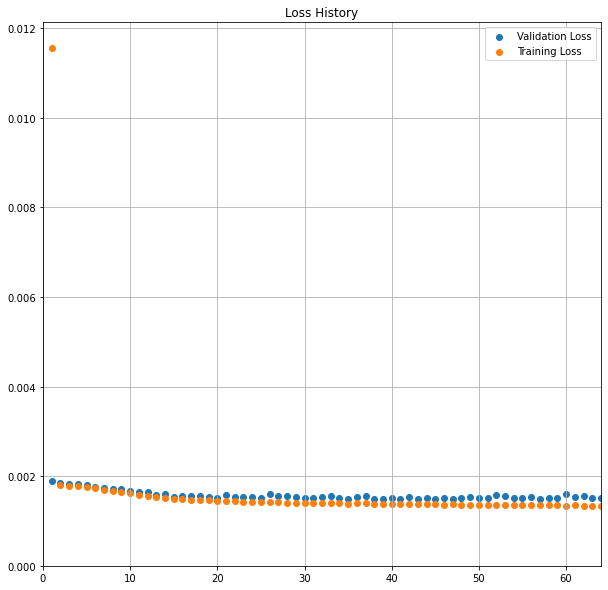

Net(
  (_modules_rec): ModuleList(
    (0): GRU(27, 120, batch_first=True)
    (1): GRU(120, 90, batch_first=True)
  )
  (_modules_lin): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=190, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=190, out_features=160, bias=True)
      (1): ReLU()
    )
  )
  (_out): Linear(in_features=160, out_features=60, bias=True)
)
Val loss: 0.001486
Test loss: 0.001507


In [23]:
from aircraft_detector.utils.plot_helper import plot_training_history

# save sorted results
sorted_results = df_results.sort_values(['Loss'], ascending=True)
sorted_results.to_csv('ENP_RESULTS.csv', header=True, index=False)
best_parameters = sorted_results.iloc[0]

# load the best settings
states_settings['states'] = best_parameters['States']
# initialize predictor class with spectrum and states settings
predictor = enp.EgoNoisePredictor(
    root_directory,
    feature_settings,
    states_settings
)
# load the data
predictor.super_verbose = True
predictor.load_datasets()
# set model configuration
predictor.set_net_configuration(config)
# increase number of epochs and patience
train_settings['epochs'] = 300
train_settings['es_patience'] = 25
# train model
model, training_losses, loss_history = predictor.train_network(train_settings)
val_loss = training_losses[1]  # losses =  [train_losses, val_losses]
# plot training history
plot_training_history(loss_history)
# test model
test_loss = predictor.test_network(model)
print(model)
print("Val loss: %.6f" % val_loss)
print("Test loss: %.6f" % test_loss)

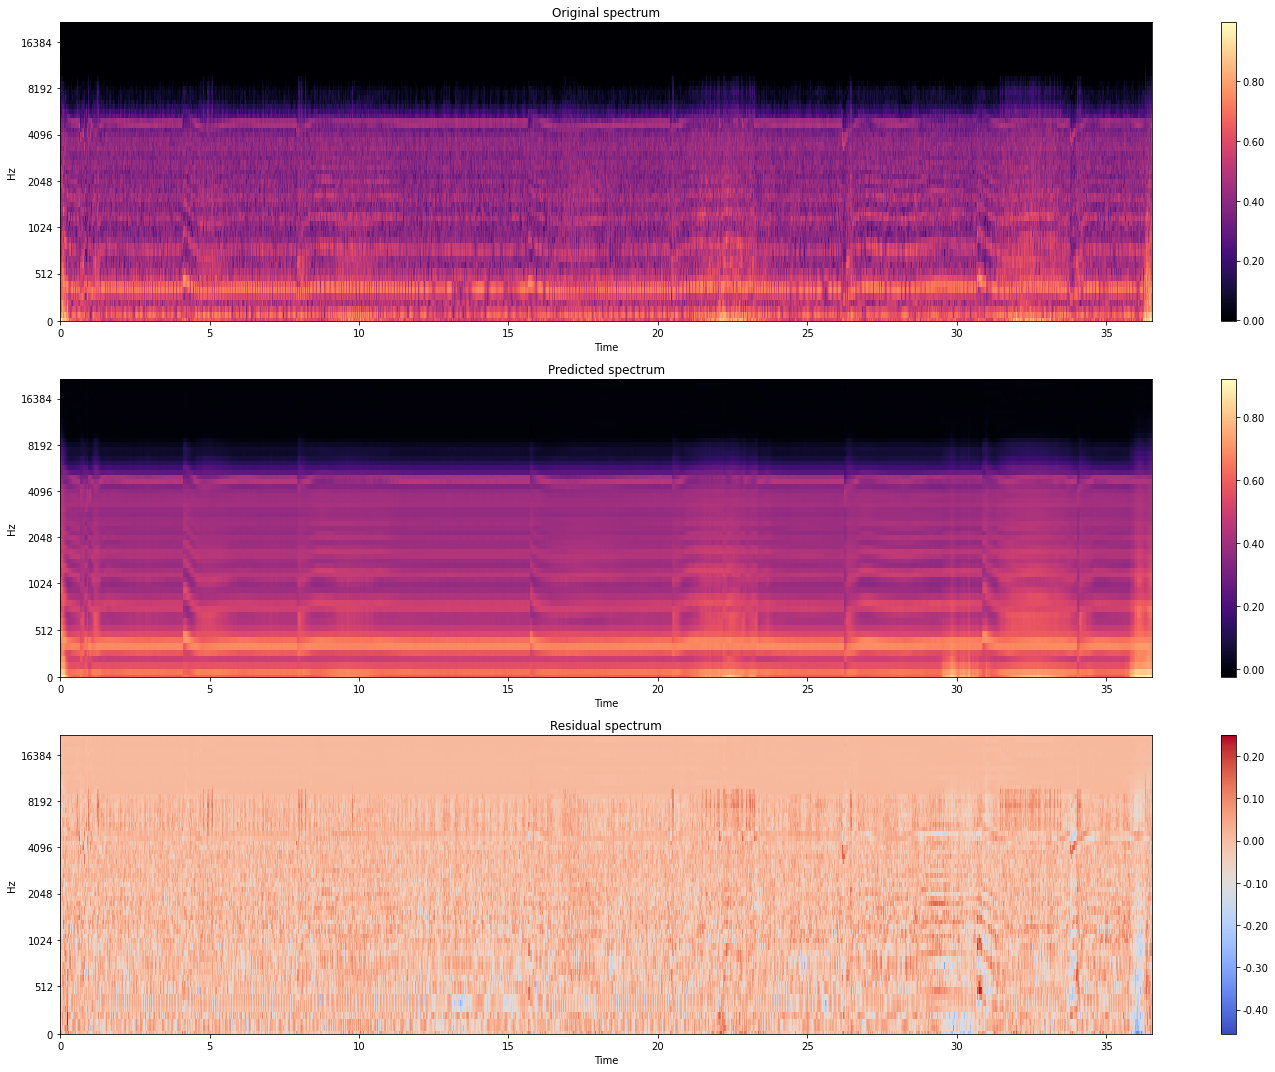

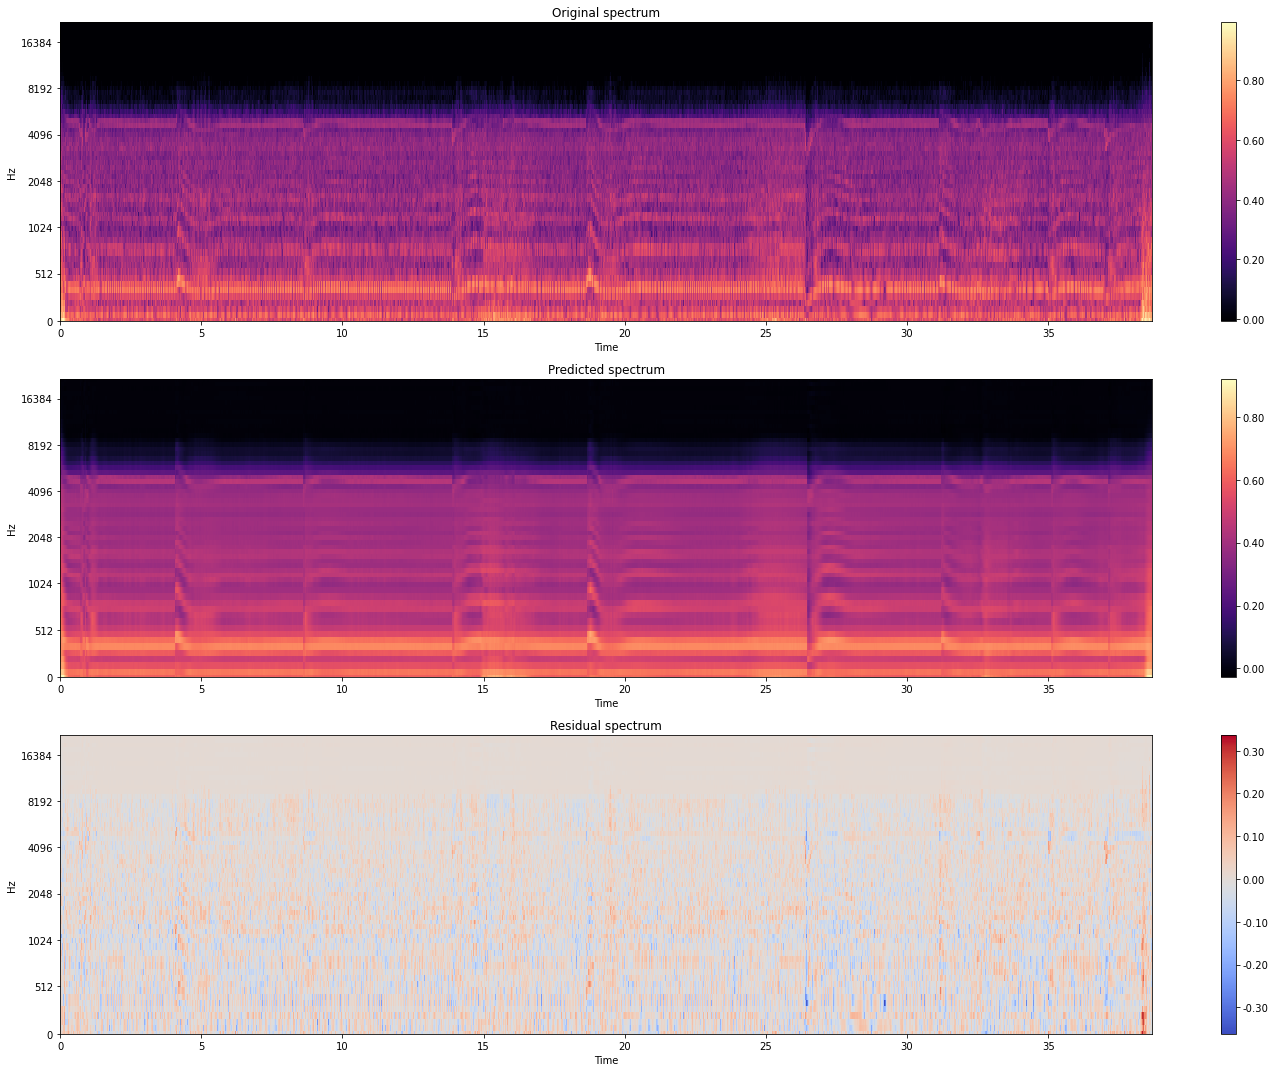

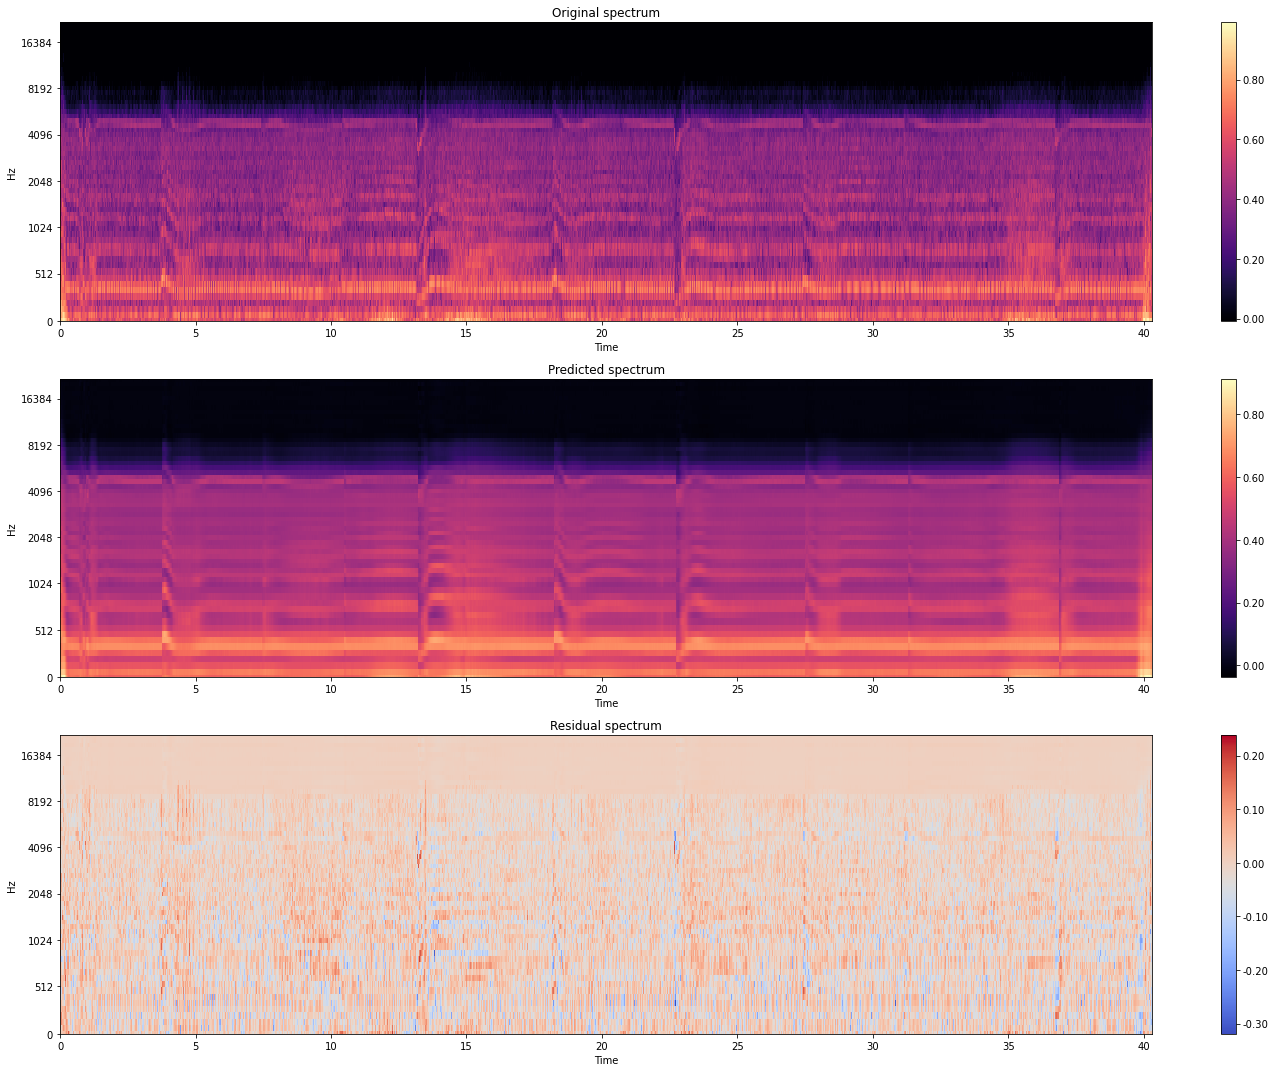

In [26]:
# save the model
dir_model = predictor.save_network(model, test_loss)
# save the output
predictor.save_network_output(model, dir_model, 'Train', plot=False)
predictor.save_network_output(model, dir_model, 'Val', plot=False)
predictor.save_network_output(model, dir_model, 'Test', plot=True)

In [11]:
best_parameters

Loss                                                       0.00173988
Context                                                             0
Type                                                              MLP
Recurrent Layers                                                    0
Recurrent Units                                                    []
Dense Layers                                                        1
Dense Units                                                     [100]
States              [rpm, rpm_delta, cmd, cmd_delta, height, vel, ...
Name: 1, dtype: object

Device: cuda.
Number of trainable parameters in network: 168390.


/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


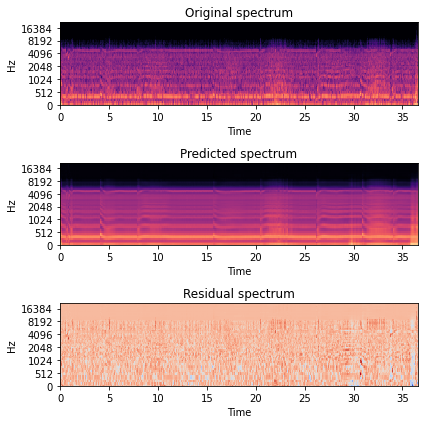

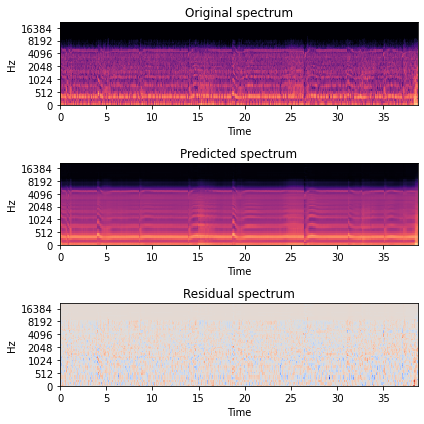

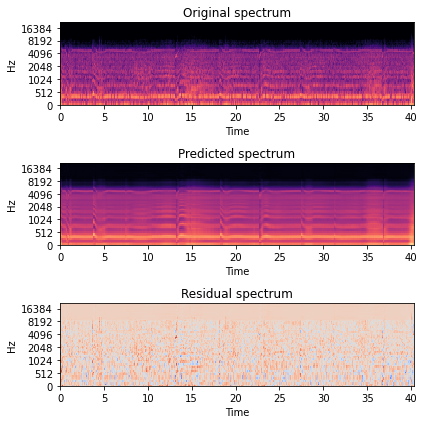

In [2]:
import aircraft_detector.ego_noise_prediction.prediction as enp
predictor = enp.EgoNoisePredictor(root_directory, feature_settings)
model, dir_model = predictor.load_network()
#predictor.save_network_output(model, dir_model, 'Train', plot=False)
#predictor.save_network_output(model, dir_model, 'Val', plot=False)
predictor.save_network_output(model, dir_model, 'Test')

In [10]:
import numpy as np
np.prod(predictor._test_set.tensors[1].size()[1:])
len(predictor._test_set.tensors)

2

In [9]:
predictor._states

{'states': ['rpm',
  'rpm_delta',
  'cmd',
  'cmd_delta',
  'height',
  'vel',
  'acc',
  'angles',
  'rates'],
 'context_frames': 1,
 'model_context': 0}

In [10]:
predictor._spectrum

{'feature': 'Mel',
 'fft_sample_rate': 44100,
 'stft_window_length': 1024,
 'stft_hop_length': 512,
 'frequency_bins': 60}

In [10]:
sorted_results

,Loss,Context,Type,Recurrent Layers,Recurrent Units,Dense Layers,Dense Units,States
258,0.001512,6,GRU,2,"[120, 90]",2,"[190, 160]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
422,0.001513,10,LSTM,1,[90],2,"[150, 170]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
419,0.001515,10,LSTM,1,[90],2,"[150, 180]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
222,0.001517,5,GRU,2,"[110, 90]",2,"[160, 200]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
378,0.001519,9,GRU,2,"[120, 80]",2,"[200, 190]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
...,...,...,...,...,...,...,...,...
278,0.001707,7,MLP,0,[],1,[80],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
12,0.001711,0,GRU,2,"[80, 70]",1,[50],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
69,0.001713,1,LSTM,2,"[80, 70]",1,[50],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
27,0.001717,0,LSTM,1,[100],2,"[190, 90]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."


In [6]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [7]:
df_results.sort_values(['Loss'], ascending=True)

,Loss,Context,Type,Recurrent Layers,Recurrent Units,Dense Layers,Dense Units,States
258,0.001512,6,GRU,2,"[120, 90]",2,"[190, 160]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
422,0.001513,10,LSTM,1,[90],2,"[150, 170]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
419,0.001515,10,LSTM,1,[90],2,"[150, 180]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
222,0.001517,5,GRU,2,"[110, 90]",2,"[160, 200]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
378,0.001519,9,GRU,2,"[120, 80]",2,"[200, 190]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
...,...,...,...,...,...,...,...,...
278,0.001707,7,MLP,0,[],1,[80],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
12,0.001711,0,GRU,2,"[80, 70]",1,[50],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
69,0.001713,1,LSTM,2,"[80, 70]",1,[50],"[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."
27,0.001717,0,LSTM,1,[100],2,"[190, 90]","[rpm, rpm_delta, cmd, cmd_delta, height, vel, ..."


In [13]:
val_loss

0.0015600839784989755

In [21]:
predictor._states

{'states': ['rpm',
  'rpm_delta',
  'cmd',
  'cmd_delta',
  'height',
  'vel',
  'acc',
  'angles',
  'rates'],
 'context_frames': 10}

In [9]:
import pandas as pd
results = pd.read_csv('ENP_RESULTS.csv')

results

In [12]:
best_results = pd.DataFrame(columns=list(range(1, 12)), index=['MLP', 'GRU', 'LSTM'])

for i, net_type in enumerate(['MLP', 'GRU', 'LSTM']):
    for context in sorted(results['Context'].unique()):
        current = results[((results['Type'] == net_type) & (results['Context'] == context))]
        best_results[context+1].iloc[i] = round(current['Loss'].iloc[0]*1e3, 3)

In [14]:
best_results.to_csv('BEST_RESULTS.csv')

In [7]:
range(1, 12)

range(1, 12)

In [13]:
best_results

,1,2,3,4,5,6,7,8,9,10,11
MLP,1.535,1.549,1.572,1.562,1.576,1.558,1.569,1.575,1.561,1.565,1.571
GRU,1.561,1.561,1.546,1.524,1.552,1.517,1.512,1.54,1.55,1.519,1.546
LSTM,1.567,1.55,1.537,1.54,1.533,1.534,1.531,1.52,1.536,1.523,1.513
